In [1]:
import sys
import os
import time
import numpy as np
import pandas as pd
import openpyxl
import pygmt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from openpyxl import load_workbook
from openpyxl import Workbook

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as dates

In [2]:
def get_client_header():
    from obspy.clients.fdsn.header import urls
    return sorted(urls.keys())


def read_file(client):   
    # Read the files - give client name as string
    df = pd.read_csv(f"catalog/{client}.txt", sep=" ", names=["starttime", "endtime", "time", "lat","lon","depth", "mag","type"])
    return df

def plot():
    files = os.listdir("catalog/")
    
    dt_all_list, mag_all_list, delay_all_list = [], [], []
    lat_all_list, lon_all_list = [], []
    for file in files:    
        df = read_file(file[:-4])
        dt_list, delay_list, mag_list, depth_list = [], [], [], []
        lat_list, lon_list = [], []
        
        
        
        for line in range(len(df)):
            
            mag = float(df["mag"].loc[line:line].to_string()[5:])
            mag_list.append(mag)
            
            depth = float(df["depth"].loc[line:line].to_string()[5:])
            depth_list.append(depth)
            
            lat = float(df["lat"].loc[line:line].to_string()[5:])
            lat_list.append(lat)

            lon = float(df["lon"].loc[line:line].to_string()[5:])
            lon_list.append(lon)
            
            df_end = df["endtime"].loc[line:line]
            df_event = df["time"].loc[line:line]
            ts_end = pd.Timestamp(f'{df_end.to_string()[5:]}', tz="UTC").strftime("%M")
            ts_event = pd.Timestamp(f'{df_event.to_string()[5:]}', tz="UTC").strftime("%M")
            delay = int(ts_end) - int(ts_event)
            if delay < 0 :
                delay +=60
            else:
                pass
            
            delay_list.append(delay)
            dt_list.append(df_event)
            
            dt_all_list.append(df_event) 
            mag_all_list.append(mag)  
            delay_all_list.append(delay) 
            
            lat_all_list.append(lat)
            lon_all_list.append(lon)
            
        event_num = len(dt_list)
        delay_mean = round(np.mean(delay_list), 2)
        
        
        
        ### Event Time vs Delay ###
        fig, ax = plt.subplots(1, 1 ,figsize =(16, 9))
        fig.tight_layout(pad=5)
        #plt.style.use("fast")
        ax.set_title(f"Event Time vs Delay    Client : {file[:-4]}  Total {event_num} Events   Avarage Delay {delay_mean}min ", size = 18)
        
        eventdates = dates.date2num(dt_list)
        img = ax.scatter([pd.to_datetime(d) for d in dt_list], delay_list,  c= mag_list, cmap="jet", vmin=1, vmax=7.5)
        
        ax.set_ylim(0, 30)
        ax.set_xlabel("Event Date time", fontsize=16)
        ax.set_ylabel("Delay [min]", fontsize=16)
        ax.grid(alpha = 0.25, linestyle='--')
        ax.tick_params(axis='both', labelsize=14)
        ax.minorticks_on()
        
        clb = plt.colorbar(img, ax=ax)
        clb.ax.tick_params(labelsize=14) 
        clb.ax.set_title("Magnitude",fontsize=15)
        
        plt.savefig(f"figures/1_{file[:-4]}_Event_Time_vs_Delay.png", dpi=400, facecolor="#ebebeb")  
        #plt.show() 
        
        
        # PLot location
        location_plot(file[:-4], lon_list, lat_list, delay_list, mag_list, event_num)
    
    
    
    # All data
    ##########
    event_num = len(dt_all_list)
    delay_mean = round(np.mean(delay_all_list), 2)
    
    
    fig, ax = plt.subplots(1, 1 ,figsize =(16, 9))
    fig.tight_layout(pad=5)
    #plt.style.use("fast")
    ax.set_title(f"Event Time vs Delay    All Clients  Total {event_num} Events   Avarage Delay {delay_mean} min ", size = 18)
        
    eventdates = dates.date2num(dt_all_list)
    img = ax.scatter([pd.to_datetime(d) for d in dt_all_list], delay_all_list,  c= mag_all_list, cmap="jet", vmin=1, vmax=7.5)
        
    ax.set_ylim(0, 30)
    ax.set_xlabel("Event Date time", fontsize=16)
    ax.set_ylabel("Delay [min]", fontsize=16)
    ax.grid(alpha = 0.25, linestyle='--')
    ax.tick_params(axis='both', labelsize=14)
    ax.minorticks_on()
        
    clb = plt.colorbar(img, ax=ax)
    clb.ax.tick_params(labelsize=14) 
    clb.ax.set_title("Magnitude",fontsize=15)
        
    plt.savefig(f"figures/Total_Event_Time_vs_Delay.png", dpi=300, facecolor="#ebebeb")      
    
    
    #########
    # PLot location
    location_plot("Total", lon_all_list, lat_all_list, delay_all_list, mag_all_list, event_num)
    
    
    
    #return delay_list
    #return df
    
def location_plot( file, lon_list, lat_list, delay_list, mag_list, event_num):   
    # Set the region
    region = [ -180, 180, -80, 80] 
    fig = pygmt.Figure()
    # make color pallets
    pygmt.makecpt(
        cmap='etopo1',
        series='-8000/5000/1000',
        continuous=True)

    # define etopo data file
    topo_data = "@earth_relief_02m"
    # plot high res topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection='M4i',
        shading=True,
        frame=True,
        transparency =[85])

    fig.coast(shorelines="0.001p,grey", 
              frame=True, resolution = "f")

    # Geological faults
    fig.plot( data="files/gem_active_faults.gmt",
              pen="0.01,#f7a7a1")

    # colorbar colormap
    pygmt.makecpt(cmap="jet", series=[1, 30], transparency =[50])
    
    mm = []
    for m in range(len(mag_list)):
        mm.append(mag_list[m]*0.02)

    fig.plot(
            x=lon_list,
            y=lat_list,
            size=mm,
            color=delay_list,
            cmap=True,
            style="cc")

    #fig.basemap(frame=[ f"+t Client : {file[:-4]}   Total {event_num} Events")
    fig.colorbar(frame='af+l"Delay [min]"')
    fig.savefig(f'figures/2_{file}_locations.png', dpi=500)
    

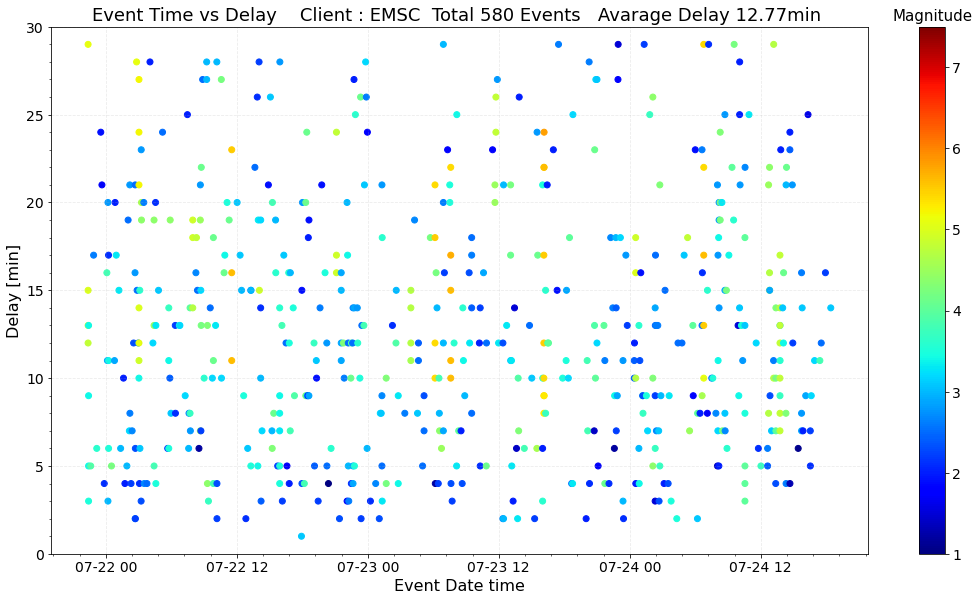

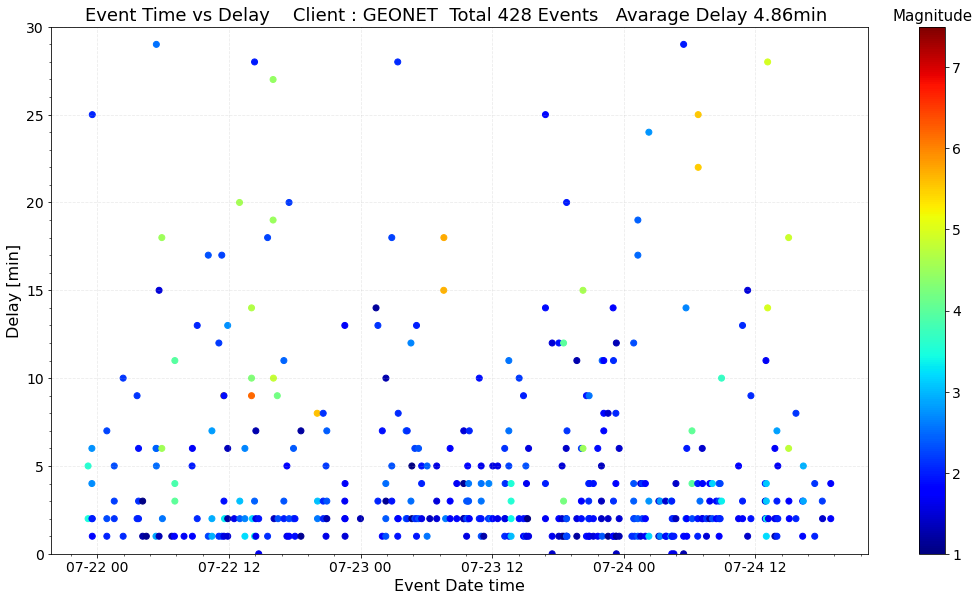

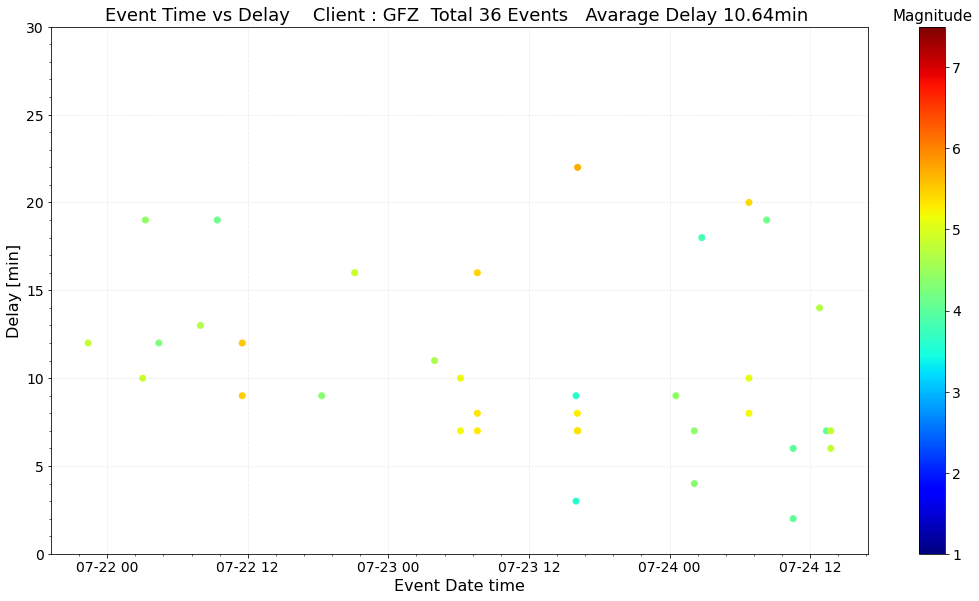

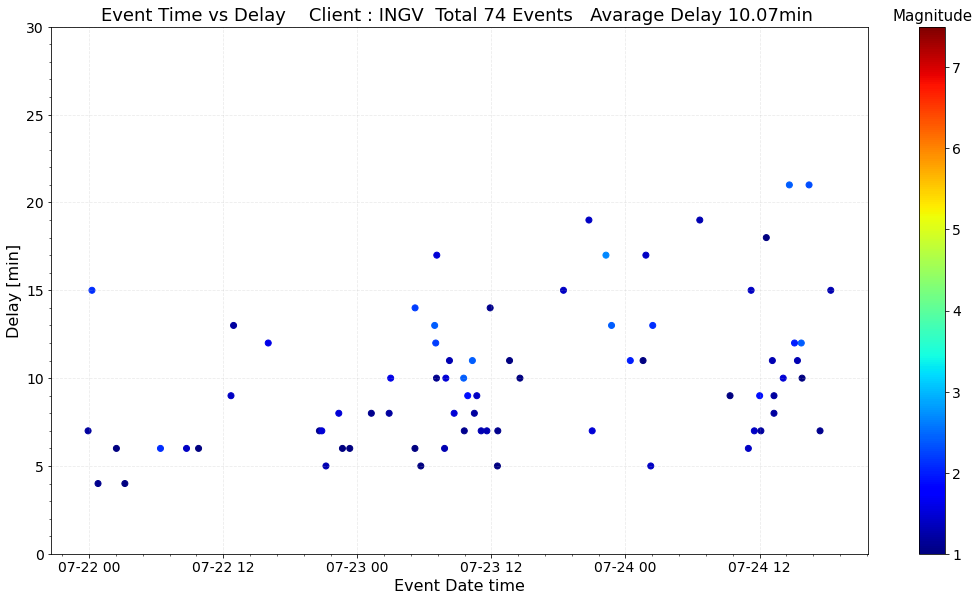

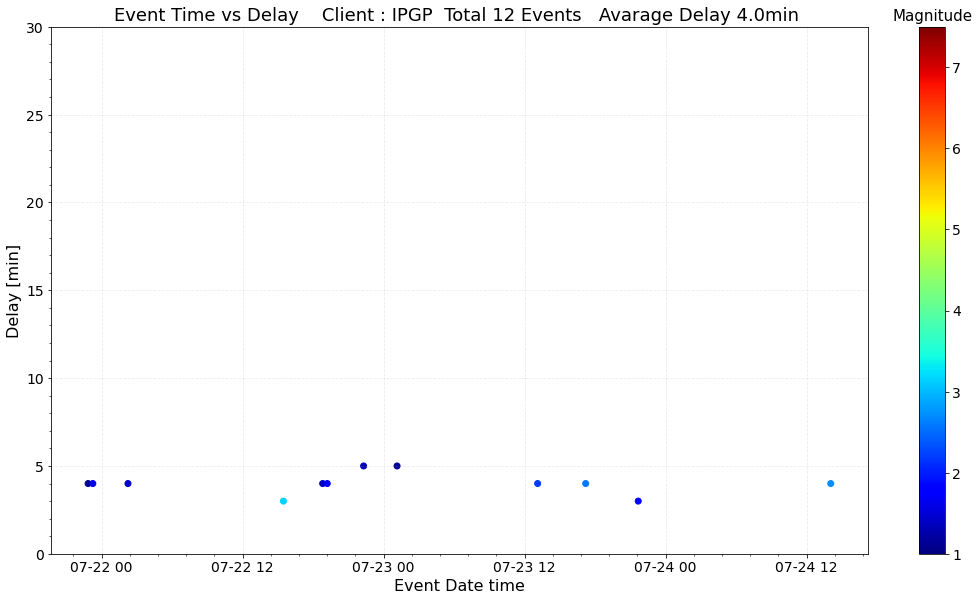

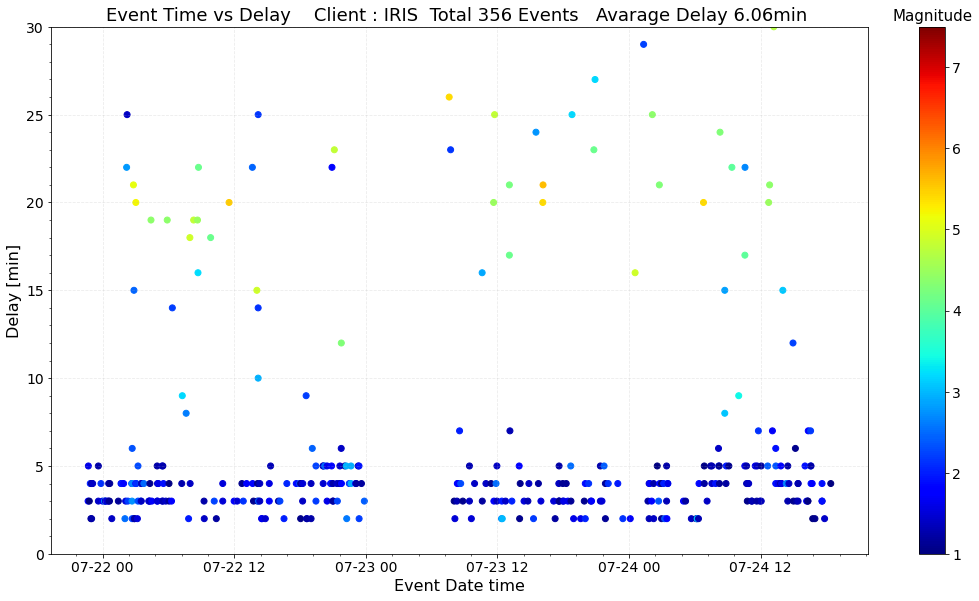

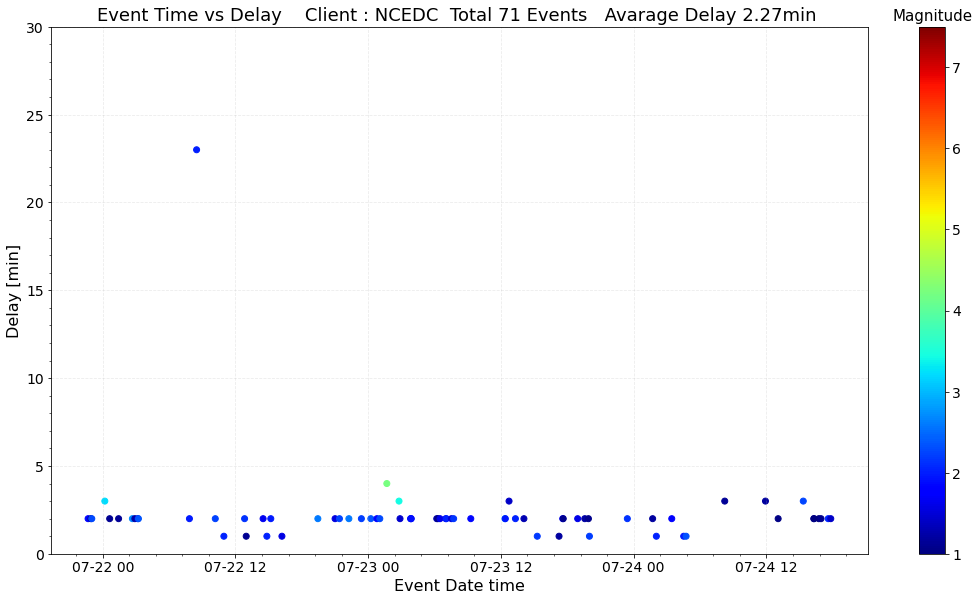

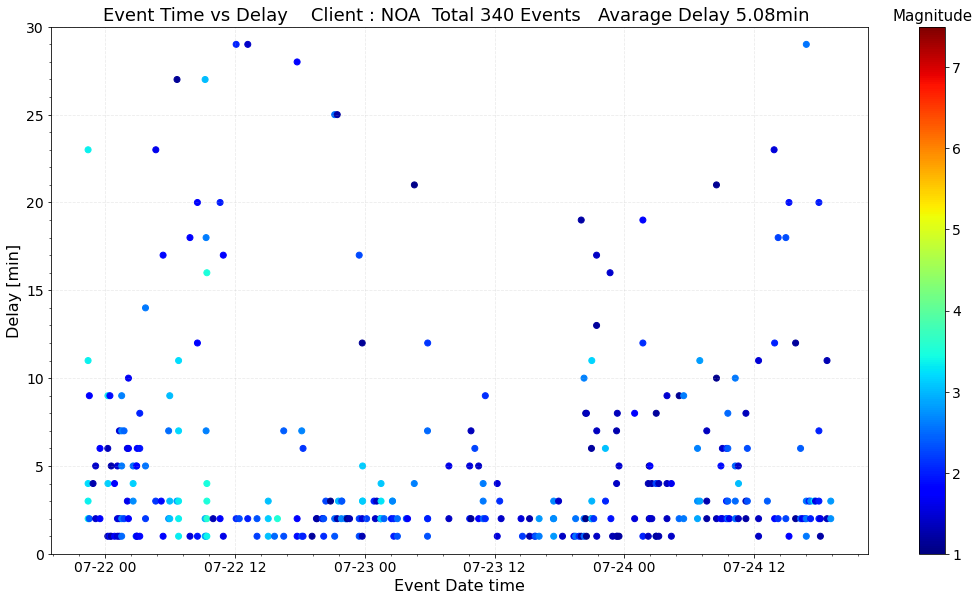

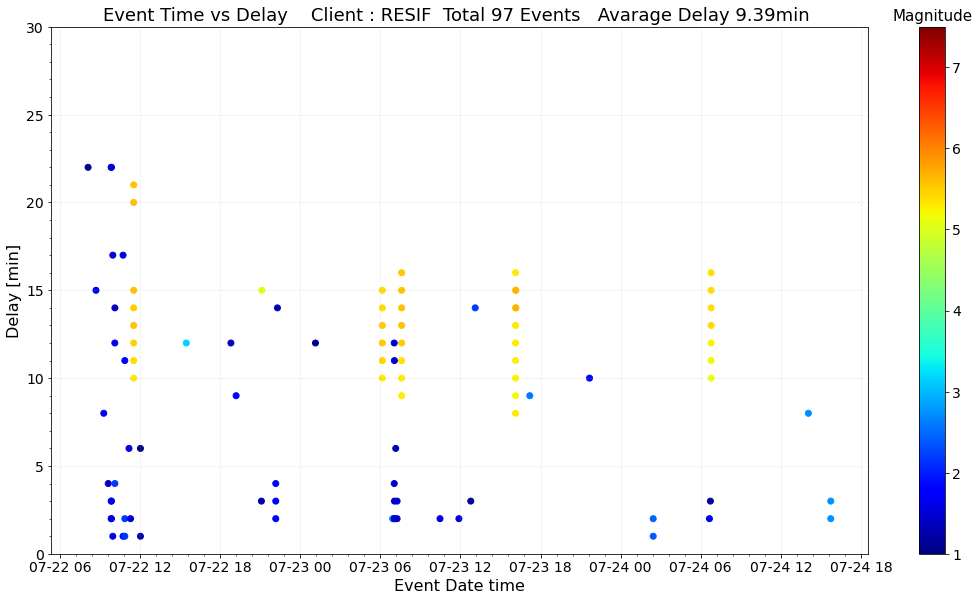

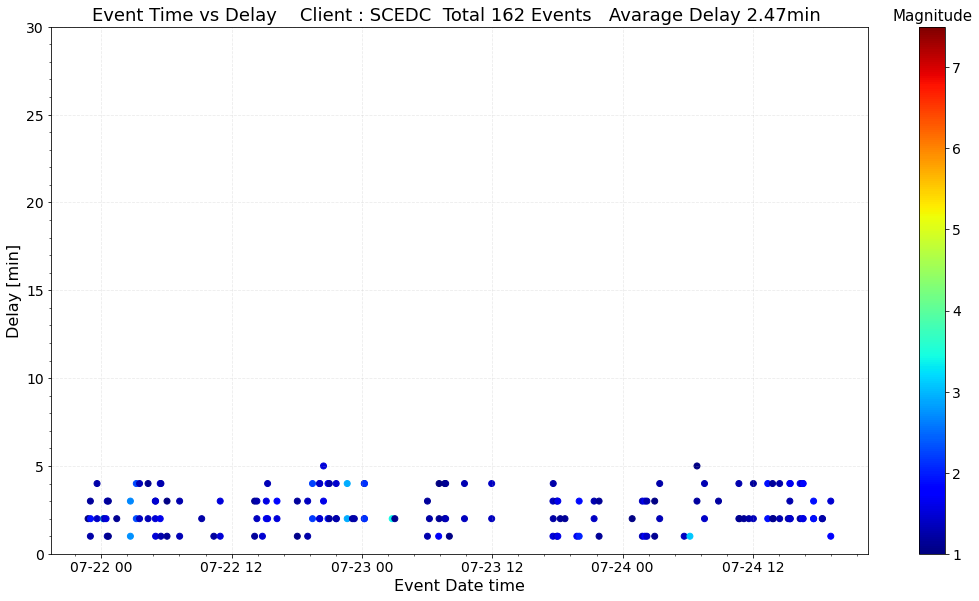

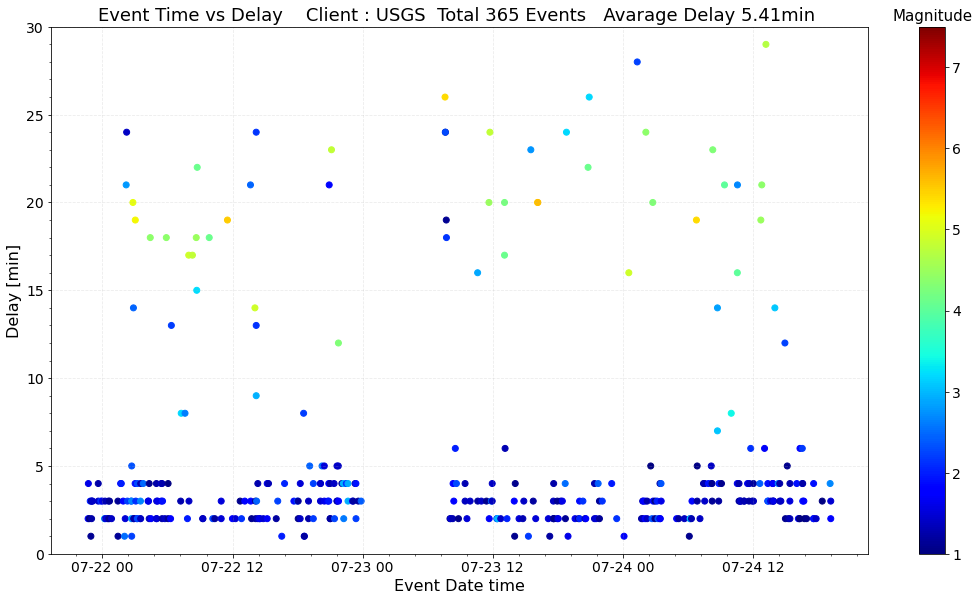

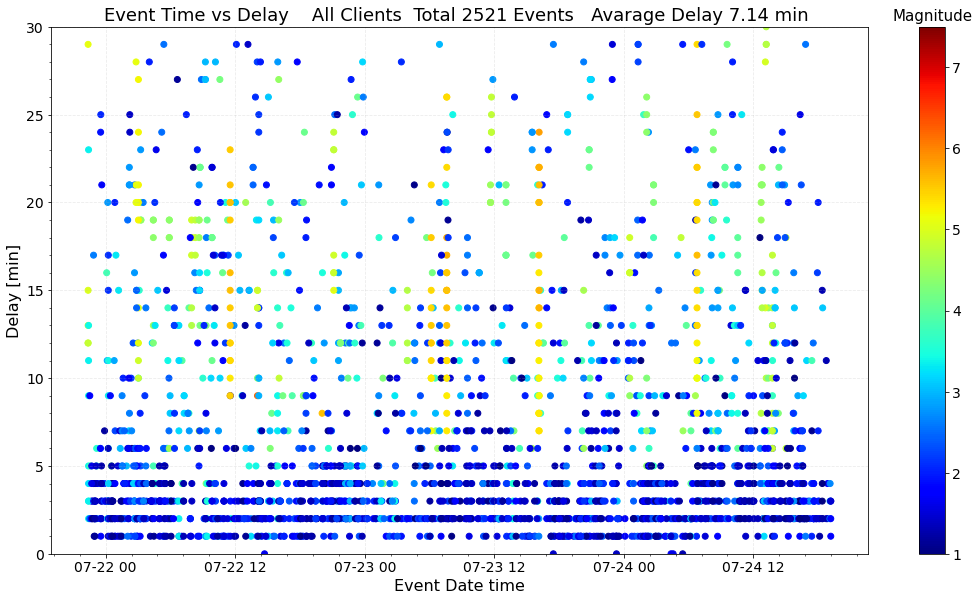

In [3]:
plot()